Osnabrück University - Computer Vision (Winter Term 2016/17) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack

# Exercise Sheet 05: Segmentation 2

## Introduction

This week's sheet should be solved and handed in before the end of **Sunday, December 11, 2016**. If you need help (and Google and other resources were not enough), feel free to contact your groups' designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

## Assignment 0: Math recap (Periodic functions) [0 Points]

This exercise is supposed to be very easy, does not give any points, and is voluntary. There will be a similar exercise on every sheet. It is intended to revise some basic mathematical notions that are assumed throughout this class and to allow you to check if you are comfortable with them. Usually you should have no problem to answer these questions offhand, but if you feel unsure, this is a good time to look them up again. You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** What are periodic functions? Can you provide a definition?

**b)** What are *amplitude*, *frequency*, *wave length*, and *phase* of a sine function? How can you change these properties?

**c)** How are sine and cosine defined for complex arguments? In what sense does this generalize the real case?

## Assignment 1: Multiscale representation [8 Points]

**a)** What is a *scale space*? What is a multiscale representation? What is the motivation for a multiscale strategy in the context of segmentation?

**b)** What is the *Gaussian pyramid*? How does the **reduce** operation work? Explain in your own words what low pass filtering is and why it should be used when building the pyramid? Implement the **reduce** operation and generate a figure similar to the one on (CV-07 slide 32).

/Users/justinshenk/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


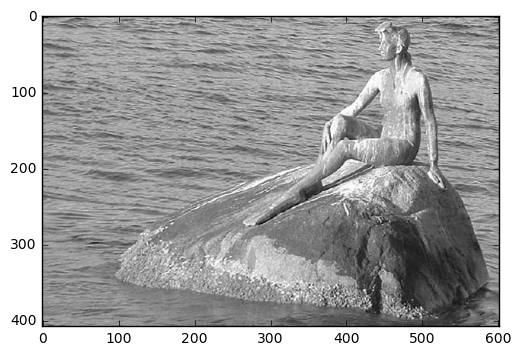

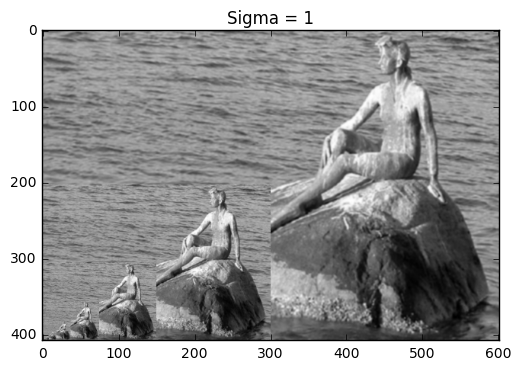

In [11]:
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
img = misc.imread('mermaid.png', mode='F')
sigma = 1
filtered = gaussian_filter(img,sigma)
scales = 3

# Initialize recursive relations.
pyramid_image = filtered

for rowIndex in range(0,filtered.shape[0]-1,2):
    for colIndex in range(0,filtered.shape[1]-1,2):
        # Sum 4-square region.
        pixelSum = filtered[rowIndex,colIndex] + filtered[rowIndex+1,colIndex] + filtered[rowIndex,colIndex+1] + filtered[rowIndex+1,colIndex+1]

        # Overwrite pyramid image.
        pyramid_image[filtered.shape[0]/2+rowIndex/2,colIndex/2] = pixelSum/4

reduced = pyramid_image
plt.gray()
plt.imshow(img)
plt.show()
plt.imshow(pyramid_image)
plt.title('Sigma = '+str(sigma))
plt.show()



**c)** What is the **expand** operation? Why can the **reduce** operation not be inverted? Implement the **expand** operation and generate an image similar to the one on (CV-07 slide 34).

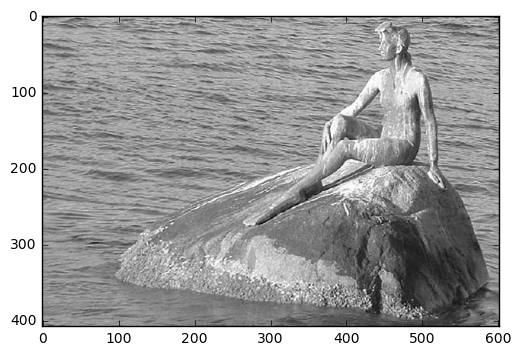

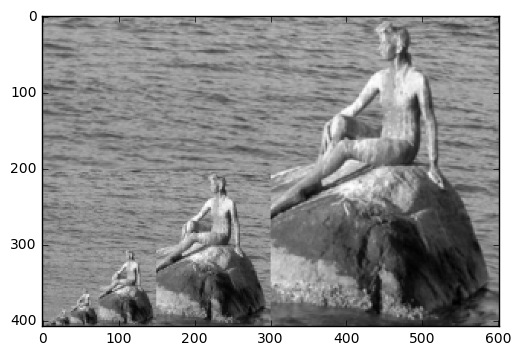

In [12]:
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter

img = misc.imread('mermaid.png', mode='F')
rows,cols = np.shape(img)
evenrow = np.zeros(cols)
interpol_mask = np.ones(np.shape(img))
for i in range(cols):
    if(i%2!=0):
        evenrow[i]=1
for i in range(rows):
    if(i%2==0):
        interpol_mask[i,:]=evenrow

sigma = 1
g_filter = gaussian_filter(pyramid_image,sigma)*(interpol_mask==0)
shifted_img= np.append(pyramid_image[1:,:], pyramid_image[-1,:].reshape(1,cols), axis=0)
e_filter = ((pyramid_image+shifted_img)/2)*(interpol_mask==1)
pyramid_image = g_filter+e_filter

#expansion 
for rowIndex in range(0, int((filtered.shape[0])/2)):
    for colIndex in range(0, int((filtered.shape[1]-1)/2)):
        # Sum 4-square region.
        gray_val = filtered[rows-1-rowIndex, colIndex]
        # Overwrite pyramid image.
        pyramid_image[rows-1-rowIndex*2,colIndex*2] = gray_val
        pyramid_image[rows-1-rowIndex*2,colIndex*2+1] = gray_val
        pyramid_image[rows-1-rowIndex*2-1,colIndex*2] = gray_val
        pyramid_image[rows-1-rowIndex*2-1,colIndex*2+1] = gray_val


plt.gray()
plt.imshow(img)
plt.show()
plt.imshow(pyramid_image)
plt.show()

**d)** What is the *Laplacian pyramid*? What is it used for? Compute the Laplacian pyramid and generate an image similar to the one on (CV-07 slide 36).

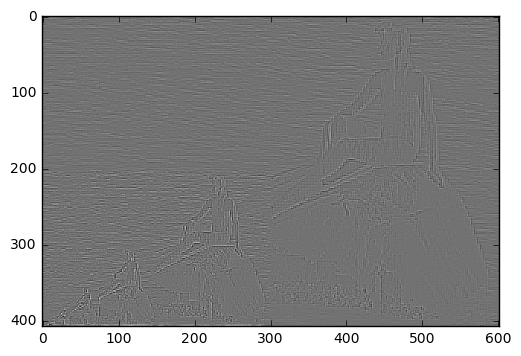

In [13]:
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt

img = misc.imread('mermaid.png', mode='F')

pyramid_image = pyramid_image-reduced # change this!
# FIXME: put your code here!


plt.gray()
plt.imshow(pyramid_image)
plt.show()

## Assignment 2: Texture Segmentation [6 Points]

**a)** What is texture? Try to define it in your own words. Can there be a standard definition? What problems do you expect for texture based segmentation? 

**b)** What is a co-occurence matrix? How can it be used to characterize texture?

**c)** Implement a function to compute the co-occurence matrix of an image (patch). Apply it and compare your results to (CV-07 slide 54).

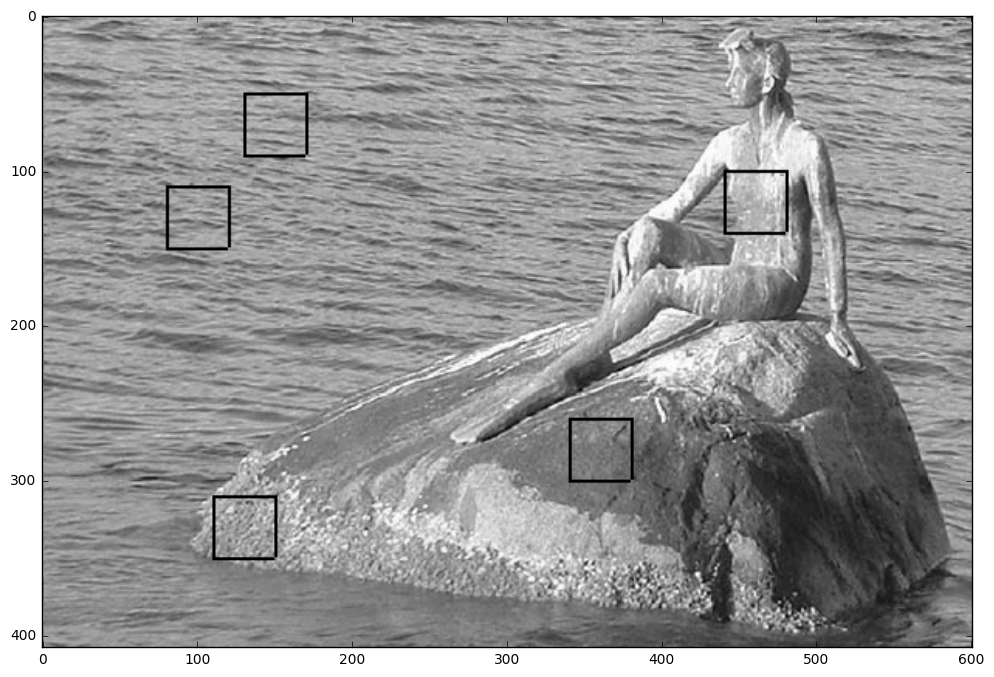

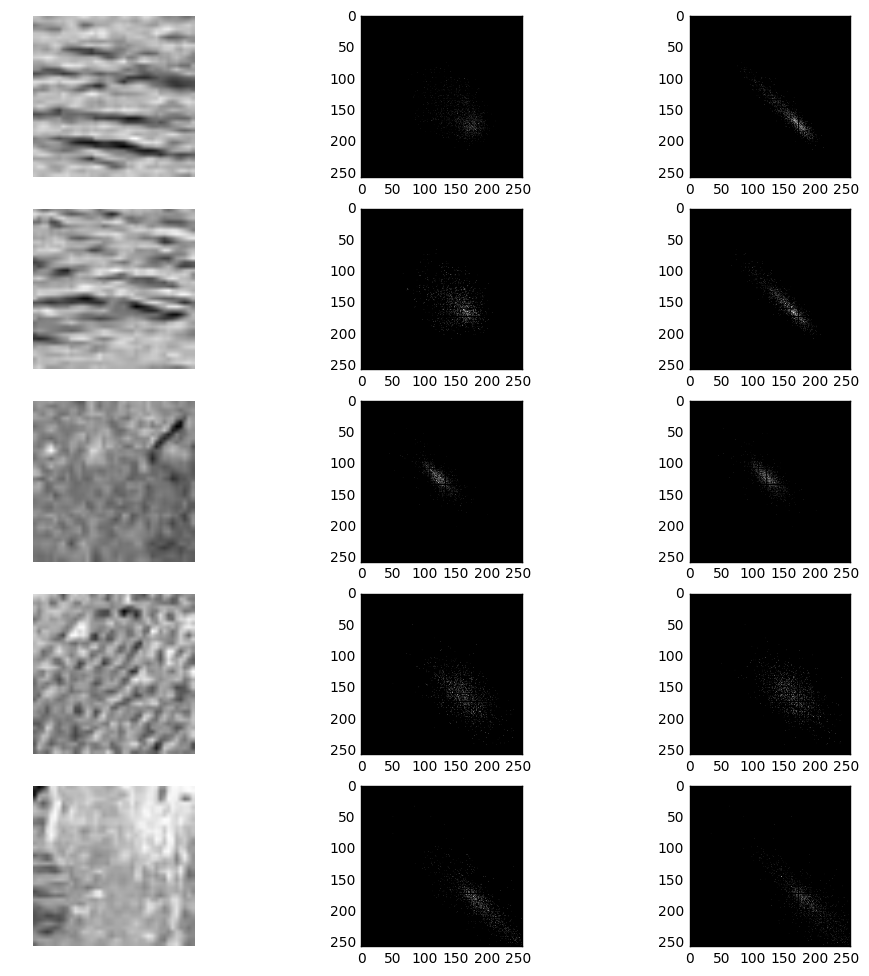

In [11]:
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt

img = misc.imread('images/mermaid.png', mode='L')

def get_patch(img, x, y, size = 40):
    """
    Extract a rectangular patch from an image and mark it in the original image.
    """
    result = img[x:x+size,y:y+size].copy()
    img[x:x+size, [y,y+1,y+size,y+size+1]] = 0
    img[[x,x+1,x+size,x+size+1], y:y+size] = 0
    return result

patches = []
patches.append(get_patch(img, 50,130))
patches.append(get_patch(img, 110,80))
patches.append(get_patch(img, 260,340))
patches.append(get_patch(img, 310,110))
patches.append(get_patch(img, 100,440))


def cooccurrence(img, dx = 1, dy = 1):
    """
    Compute a co-occurence matrix for the given image.
    
    Args:
        img          the grayscale image (uint8)
        dx,dy        the offset between the two reference points

    Returns:
        matrix       the co-occurence matrix
    """
    
    matrix = np.empty((256,256))
    rows,cols = np.shape(img)
    shifted_img = img
    while(dx>0):
        shifted_img= np.append(shifted_img[1:,:], shifted_img[-1,:].reshape(1,cols), axis=0)
        dx-=1
    while(dy>0):
        shifted_img = np.append(shifted_img[:,1:], shifted_img[:,-1].reshape(rows,1), axis=1)
        dy-=1
    
    n = rows*cols
    for g1 in range(256):
        for g2 in range(256):
            matrix[g1,g2] = (1/n)*np.sum(np.logical_and(img-g1==0,shifted_img-g2==0))
            
    # FIXME: put your code here!

    return matrix


plt.figure(figsize=(12, 12))
plt.gray()
plt.imshow(img)
plt.show()


plt.figure(figsize=(12, 12))
i = 0
for p in patches:
    plt.subplot(len(patches),3,i+1); plt.axis('off'); plt.imshow(p)
    plt.subplot(len(patches),3,i+2); plt.imshow(cooccurrence(p,1,0))
    plt.subplot(len(patches),3,i+3); plt.imshow(cooccurrence(p,0,1))
    i += 3
plt.show()

## Assignment 3: Region merging [6 Points]

Implement the *region merging* algorithm (CV-07 slide 39) and apply it to the image `segments.png` (or some part of it). Use a simple *homogeneity condition*, e.g. that the maximal difference between gray values in a segment is not larger than a given threshold.

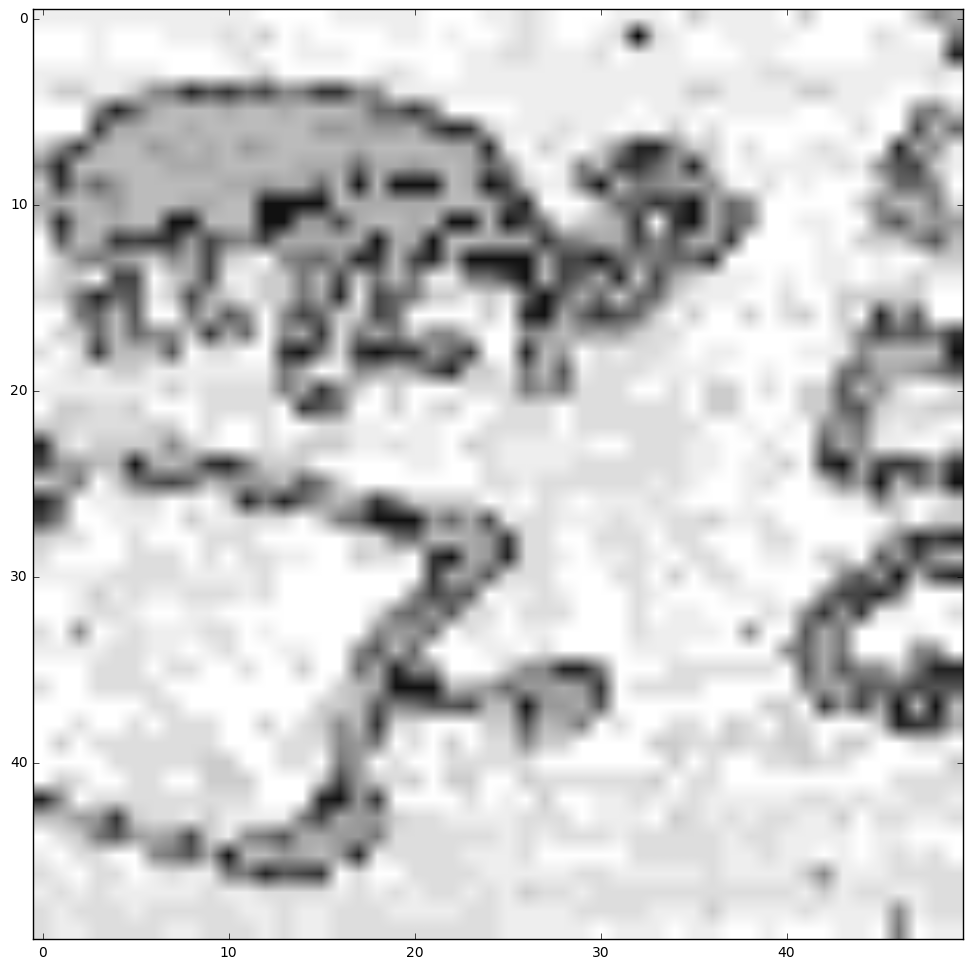

In [1]:
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt

img = misc.imread('segments.png', mode='F')
img = img[:50,:50]
segmented_image = np.empty(img.shape)

def homogeneous(img,s1,s2,h):
    sum1 = 0
    for g1 in s1:
        sum1+=img[g1]
    sum1/=len(s1)
    sum2 = 0
    for g2 in s2:
        sum2+=img[g2]
    sum2/=len(s2)
    return np.abs(sum1-sum2)<h
    
def merge(s,s1,s2):
    s.remove(s1)
    s.remove(s2)
    for ss2 in s2:
        s1.append(ss2)
    s.append(s1)

def segmentize(img):
    segment = []
    for i in range(len(img)):
        for j in range(len(img[i])):
            segment.append([(i,j)])
    return segment

segment = segmentize(img)
def region_merge(img, h, segment, t):
    t = 0
    for i,j in ((ii,jj) for ii in range(len(segment)) for jj in range(ii+1,len(segment))):
        if homogeneous(img,segment[i],segment[j],h):
            t = 1
            merge(segment,segment[i],segment[j])
            break
    return t
            
                
t=1
while t==1:
    t = region_merge(img, 5, segment, t)

n=0
for s in segment:
    for ss in s:
        segmented_image[ss] = n
    n+=1
    
plt.figure(figsize=(12, 12))
plt.gray()
plt.imshow(segmented_image)
plt.show()